# Chron.jl demo
This Jupyter notebook demonstrates the [Chron.jl](https://github.com/brenhinkeller/Chron.jl) Julia package for integrated Bayesian eruption age and stratigraphic age-depth modelling, based in part on the work of [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) Geochemical Perspectives Letters 8, 31-35

Any code from this notebook can also be copied and pasted into the Julia REPL or a .jl script

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file
***
## Load external resources

In [1]:
# Load (and install if necessary) the Chron.jl package
if VERSION>=v"0.7"
    using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
else
    using Compat
end

try
    using Chron
catch
    Pkg.clone("https://github.com/brenhinkeller/Chron.jl")
    using Chron
end

using Plots; gr(); default(fmt = :png)

## Enter sample information
This example data is from Clyde et al. (2016) "Direct high-precision
U–Pb geochronology of the end-Cretaceous extinction and calibration of
Paleocene astronomical timescales" EPSL 452, 272–280.
doi: 10.1016/j.epsl.2016.07.041

In [2]:
nSamples = 5 # The number of samples you have data for
smpl = NewStratAgeData(nSamples)
smpl.Name      =   ("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70",)
smpl.Height[:] =   [     -52.0,      44.0,      54.0,      82.0,      93.0,]
smpl.Height_Sigma[:] = [   3.0,       1.0,       3.0,       3.0,       3.0,]
smpl.Age_Sidedness[:] = zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "DenverUPbExampleData/" # Where are the data files?
smpl.inputSigmaLevel = 2 # i.e., are the data files 1-sigma or 2-sigma. Integer.

AgeUnit = "Ma" # Unit of measurement for ages and errors in the data files
HeightUnit = "cm"; # Unit of measurement for Height and Height_Sigma

## Configure and run eruption/deposition age model
To learn more about the eruption/deposition age estimation model, see also [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) and the [BayeZirChron demo notebook](http://brenh.in/BayeZirChron)

In [3]:
# Number of steps to run in distribution MCMC
distSteps = 10^6
distBurnin = floor(Int,distSteps/100)

# Choose the form of the prior distribution to use. 
# A variety of potentially useful distributions are provided in DistMetropolis.jl - Options include UniformDisribution,
# TriangularDistribution, BootstrappedDistribution, and MeltsVolcanicZirconDistribution - or you can define your own.
dist = TriangularDistribution;

# Run MCMC to estimate saturation and eruption/deposition age distributions
smpl = tMinDistMetropolis(smpl,distSteps,distBurnin,dist);

Estimating eruption/deposition age distributions...
1: KJ08-157
2: KJ04-75
3: KJ09-66
4: KJ04-72
5: KJ04-70


In [4]:
# Let's see what that did
run(`ls $(smpl.Path)`); sleep(0.5)
results = readdlm(smpl.Path*"results.csv",',')

KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_rankorder.pdf
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_rankorder.pdf
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_rankorder.pdf
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_rankorder.pdf
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_rankorder.pdf
KJ12-01.csv
results.csv


6×5 Array{Any,2}:
 "Sample"      "Age"    "2.5% CI"    "97.5% CI"   "sigma" 
 "KJ08-157"  66.065   66.0311      66.0897       0.0151912
 "KJ04-75"   65.9744  65.9239      66.0056       0.0198522
 "KJ09-66"   65.9476  65.9146      65.9808       0.0167358
 "KJ04-72"   65.9532  65.9193      65.9738       0.0135808
 "KJ04-70"   65.8518  65.7856      65.898        0.0288138

To see what one of these plots looks like, try pasting this into a markdown cell like the one below
```
<img src="DenverUPbExampleData/KJ04-75_rankorder.pdf" align="left"/>
```

For each sample, the eruption/deposition age distribution is inherently asymmetric. For example:
<img src="DenverUPbExampleData/KJ04-70_distribution.pdf" align="left"/>

Consequently, rather than simply taking a mean and standard deviation of the stationary distribtuion of the Markov Chain, the histogram of the stationary distribution is fit to an empirical distribution function of the form 

$$ f = a * \exp\left(d^2e^2\frac{x - b}{c}\left(\frac{1}{2} - \frac{atan\left(\frac{x - b}{c}\right)}{\pi}\right)  - \frac{d^2}{e^2}\frac{x - b}{c}\left(\frac{1}{2} + \frac{atan\left(\frac{x - b}{c}\right)}{\pi}\right)\right) $$ 

i.e., an asymmetric exponential function with two log-linear segments joined with an arctangent sigmoid. After fitting, the five parameters $a$ - $e$ are stored in `smpl.params` and passed to the stratigraphic model



## Configure and run stratigraphic model
note: to spare Binder's servers, this demo uses
```
config.nsteps = 3000 
config.burnin = 2000*npoints_approx
```
However, you probably want higher numbers for a publication-quality result, for instance 
```
config.nsteps = 15000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
```

In [5]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If you in doubt, you can probably leave these parameters as-is
config.resolution = 1.0 # Same units as sample height. Smaller is slower!
config.bounding = 0.1 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 3000 # Number of steps to run in distribution MCMC
config.burnin = 2000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolisDist(smpl, config); sleep(0.5)

Generating stratigraphic age-depth model...
Burn-in: 350000 steps


Burn-in... 97%|████████████████████████████████████████ |  ETA: 0:00:03

Burn-in...100%|█████████████████████████████████████████| Time: 0:01:23
Collecting...100%|██████████████████████████████████████| Time: 0:02:03


## Plot results

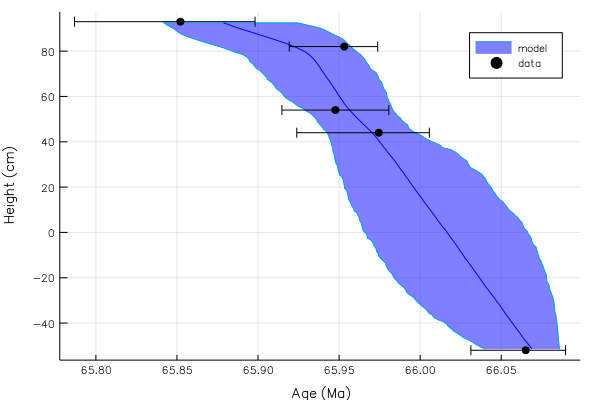

In [6]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(minimum(mdl.Height),0.5,:blue), label="model")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="")
plot!(hdl, smpl.Age, smpl.Height, xerror=(smpl.Age-smpl.Age_025CI,smpl.Age_975CI-smpl.Age),label="data",seriestype=:scatter,color=:black)
plot!(hdl, xlabel="Age ($AgeUnit)", ylabel="Height ($HeightUnit)")
savefig(hdl,"AgeDepthModel.pdf");
display(hdl)

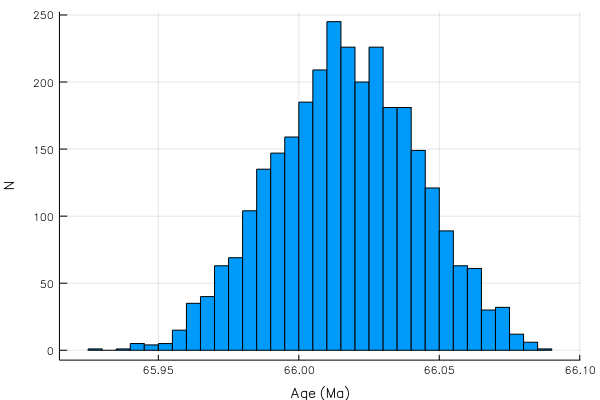

Interpolated age: 66.01666730767516 +0.04962990346399465/-0.050726847780197204 Ma

In [7]:
# Interpolate results at KTB (height = 0)
height = 0
KTB = linterp1s(mdl.Height,mdl.Age,height)
KTB_min = linterp1s(mdl.Height,mdl.Age_025CI,height)
KTB_max = linterp1s(mdl.Height,mdl.Age_975CI,height)
print("Interpolated age: $KTB +$(KTB_max-KTB)/-$(KTB-KTB_min) Ma")

# We can also interpolate the full distribution:
interpolated_distribution = Array{Float64}(undef,size(agedist,2))
for i=1:size(agedist,2)
    interpolated_distribution[i] = linterp1s(mdl.Height,agedist[:,i],height)
end
histogram(interpolated_distribution, xlabel="Age (Ma)", ylabel="N", label="")

There are other things we can plot as well, such as deposition rate:

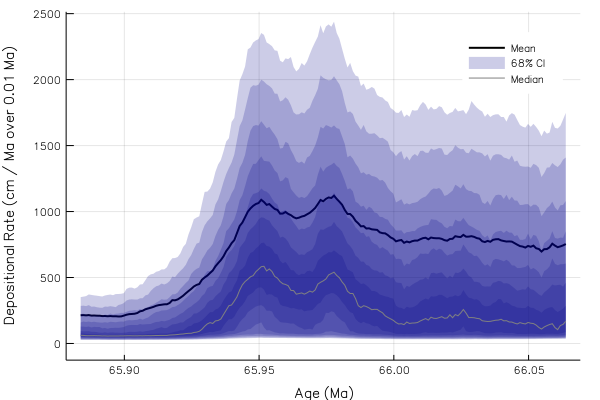

  0.208933 seconds (155.88 k allocations: 47.104 MiB, 7.78% gc time)


In [8]:
# Set bin width and spacing
binwidth = 0.01 # Myr
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] = abs.(heights[1:end-spacing] - heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = pctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = pctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = pctile(dhdt_dist,20,dim=2)
dhdt_80p = pctile(dhdt_dist,80,dim=2)
dhdt_25p = pctile(dhdt_dist,25,dim=2)
dhdt_75p = pctile(dhdt_dist,75,dim=2)
dhdt_30p = pctile(dhdt_dist,30,dim=2)
dhdt_70p = pctile(dhdt_dist,70,dim=2)
dhdt_35p = pctile(dhdt_dist,35,dim=2)
dhdt_65p = pctile(dhdt_dist,65,dim=2)
dhdt_40p = pctile(dhdt_dist,40,dim=2)
dhdt_60p = pctile(dhdt_dist,60,dim=2)
dhdt_45p = pctile(dhdt_dist,45,dim=2)
dhdt_55p = pctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(minimum(mdl.Height),0.2,:darkblue), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($AgeUnit)", ylabel="Depositional Rate ($HeightUnit / $AgeUnit over $binwidth $AgeUnit)", fg_color_legend=:white)
# savefig(hdl,"DepositionRateModelCI.pdf")
display(hdl)